### Mask R-CNN on MoNuSeg Dataset
 finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*MoNuSeg*](https://monuseg.grand-challenge.org/Data/). Training set contains 30 images with around 22,000 nuclear boundary annotations.

1. we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torchvision
from torchsummary import summary
import torch.utils as utils
from torchvision.ops.roi_align import RoIAlign
import numpy as np
import torchvision.transforms as transforms
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from tqdm import tqdm
import shutil
from xml.dom import minidom
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.draw import polygon
from scipy.io import savemat
import torch.utils.data
from PIL import Image
from pathlib import Path
import sklearn
import shutil
import os
import numpy as np
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.draw import polygon
from scipy.io import savemat
import torch
import torch.utils.data
from PIL import Image
from pathlib import Path
import re
import torch.nn.functional as F
import torchvision.transforms as transforms

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-o7_470nm
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-o7_470nm
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263898 sha256=b73d372783a6dad2ca594e722110199a534c3fbf503306a6c02328b996497965
  Stored in directory: /tmp/pip-ephem-wheel-cache-u41s2581/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for MoNuSeg

---



Let's write a dataset for the MoNuSeg dataset.
As image size is 1000x1000, we will divide images and mask in 256x256 patches

In [ ]:
# DON'T RUN
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jiZIr64TaavSvLKiq1a-wGksskB18zR0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jiZIr64TaavSvLKiq1a-wGksskB18zR0" -O monuseg.zip && rm -rf /tmp/cookies.txt


--2021-07-27 15:28:30--  https://docs.google.com/uc?export=download&confirm=Qxne&id=1jiZIr64TaavSvLKiq1a-wGksskB18zR0
Resolving docs.google.com (docs.google.com)... 108.177.12.102, 108.177.12.138, 108.177.12.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-2k-docs.googleusercontent.com/docs/securesc/j7lh6innmsqi1todaddjngu2auku9g8t/aj38hpu2lumbio15tnstujsg8d53j39d/1627399650000/10362689357213312017/02668928288582761930Z/1jiZIr64TaavSvLKiq1a-wGksskB18zR0?e=download [following]
--2021-07-27 15:28:30--  https://doc-0o-2k-docs.googleusercontent.com/docs/securesc/j7lh6innmsqi1todaddjngu2auku9g8t/aj38hpu2lumbio15tnstujsg8d53j39d/1627399650000/10362689357213312017/02668928288582761930Z/1jiZIr64TaavSvLKiq1a-wGksskB18zR0?e=download
Resolving doc-0o-2k-docs.googleusercontent.com (doc-0o-2k-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connectin

In [ ]:
!unzip "/content/monuseg.zip"

Archive:  /content/monuseg.zip
   creating: MoNuSegTrainingData/
   creating: MoNuSegTrainingData/Annotations/
  inflating: MoNuSegTrainingData/Annotations/TCGA-18-5592-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-21-5784-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-21-5786-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-38-6178-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-49-4488-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-50-5931-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-A7-A13E-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-A7-A13F-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-AR-A1AK-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-AR-A1AS-01Z-00-DX1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-AY-A8YK-01A-01-TS1.xml  
  inflating: MoNuSegTrainingData/Annotations/TCGA-B0-5698-01Z-00

Here is one example of an image in the dataset

In [ ]:
def generate_masks(shape, xml_file):
	"""
	Given the image shape and path to annotations (xml file),
	generate a bit mask with the region inside a contour being white
	shape: The image shape on which bit mask will be made
	xml_file: path relative to the current working directory
	where the xml file is present
	Returns: A image of given shape with region inside contour being white..
	"""
	# DOM object created by the minidom parser
	xDoc = minidom.parse(xml_file)

	# List of all Region tags
	regions = xDoc.getElementsByTagName('Region')

	# List which will store the vertices for each region
	xy = []
	for region in regions:
		vertices = region.getElementsByTagName('Vertex')

		# The vertices of a region will be stored in a array
		vw = np.zeros((len(vertices), 2))

		for index, vertex in enumerate(vertices):
			# Storing the values of x and y coordinate after conversion
			vw[index][0] = float(vertex.getAttribute('X'))
			vw[index][1] = float(vertex.getAttribute('Y'))

		# Append the vertices of a region
		xy.append(np.int32(vw))

	# Creating a completely black image
	mask = np.zeros(shape, np.int32)

	# For each contour, fills the area inside it
	# Warning: If a list of contours is passed, overlapping regions get buggy output
	# Comment out the below line to check, and if the bug is fixed use this
	# cv2.drawContours(mask, xy, -1, (255,255,255), cv2.FILLED)
	j=1
	for i,contour in enumerate(xy):
		if(xml_file.find('-')>=0):
			r,c = polygon(np.array(xy[i])[:,1],np.array(xy[i])[:,0],shape=shape)
		else:
			r,c = np.array(xy[i])[:,1],np.array(xy[i])[:,0]

		mask[r,c]=i+1	
	return mask

Making 16 patches of each image and mask ans storing them in content/MoNuSegP folder

In [ ]:
def make_patches_img(img_inp,filename,folder):
    trans = transforms.ToPILImage()
    trans_tensor = transforms.ToTensor()
    img = trans_tensor(img_inp)
    kernel = 250
    ## num = 16
    patch1 = trans(img[:,0:kernel, 0:kernel])
    patch2 = trans(img[:,0:kernel, kernel:500])
    patch3 = trans(img[:,0:kernel, (kernel+250):750])
    patch4 = trans(img[:,0:kernel, (kernel+500):1000])
    patch5 = trans(img[:,kernel:500, 0:kernel])
    patch6 = trans(img[:,(kernel+250):750, 0:kernel])
    patch7 =  trans(img[:,(kernel+500):1000, 0:kernel])
    patch8 = trans(img[:,kernel:500, kernel:500])
    patch9 = trans(img[:,kernel:500, (kernel+250):750])
    patch10 = trans(img[:,kernel:500, (kernel+500):1000])
    patch11 = trans(img[:,(kernel+250):750, kernel:500])
    patch12 = trans(img[:,(kernel+500):1000, kernel:500])
    patch13 = trans(img[:,(kernel+250):750, (kernel+250):750])
    patch14 = trans(img[:,(kernel+250):750, (kernel+500):1000])
    patch15 = trans(img[:,(kernel+500):1000, (kernel+250):750])
    patch16 = trans(img[:,(kernel+500):1000,(kernel+500):1000])

    #save the images in seperate files in a new folder
    path1 = os.path.join(folder,'Tissue Images',"1_"+filename)
    patch1.save(path1)
    path2 = os.path.join(folder,'Tissue Images',"2_"+filename)
    patch2.save(path2)
    path3 = os.path.join(folder,'Tissue Images',"3_"+filename)
    patch3.save(path3)
    path4 = os.path.join(folder,'Tissue Images',"4_"+filename)
    patch4.save(path4)
    path5 = os.path.join(folder,'Tissue Images',"5_"+filename)
    patch5.save(path5)
    path6 = os.path.join(folder,'Tissue Images',"6_"+filename)
    patch6.save(path6)
    path7 = os.path.join(folder,'Tissue Images',"7_"+filename)
    patch7.save(path7)
    path8 = os.path.join(folder,'Tissue Images',"8_"+filename)
    patch8.save(path8)
    path9 = os.path.join(folder,'Tissue Images',"9_"+filename)
    patch9.save(path9)
    path10 = os.path.join(folder,'Tissue Images',"10_"+filename)
    patch10.save(path10)
    path11 = os.path.join(folder,'Tissue Images',"11_"+filename)
    patch11.save(path11)
    path12 = os.path.join(folder,'Tissue Images',"12_"+filename)
    patch12.save(path12)
    path13 = os.path.join(folder,'Tissue Images',"13_"+filename)
    patch13.save(path13)
    path14 = os.path.join(folder,'Tissue Images',"14_"+filename)
    patch14.save(path14)
    path15 = os.path.join(folder,'Tissue Images',"15_"+filename)
    patch15.save(path15)
    path16 = os.path.join(folder,'Tissue Images',"16_"+filename)
    patch16.save(path16)

    return 
 
def make_patches_mask(mask,filename, folder):

    kernel = 250
    ## num = 16
    patch1 = mask[0:kernel,0:kernel]
    patch2 = mask[0:kernel,kernel:500]
    patch3 = mask[0:kernel,(kernel+250):750]
    patch4 = mask[0:kernel, (kernel+500):1000]
    patch5 = mask[kernel:500, 0:kernel]
    patch6 = mask[(kernel+250):750, 0:kernel]
    patch7 = mask[(kernel+500):1000, 0:kernel]
    patch8 = mask[kernel:500, kernel:500]
    patch9 = mask[kernel:500, (kernel+250):750]
    patch10 = mask[kernel:500, (kernel+500):1000]
    patch11 = mask[(kernel+250):750, kernel:500]
    patch12 = mask[(kernel+500):1000, kernel:500]
    patch13 = mask[(kernel+250):750, (kernel+250):750]
    patch14 = mask[(kernel+250):750, (kernel+500):1000]
    patch15 = mask[(kernel+500):1000, (kernel+250):750]
    patch16 = mask[(kernel+500):1000,(kernel+500):1000]

    #save the masks in seperate files in a new folder
    path1 = os.path.join(folder,'Annotations',"1_"+filename.split('.')[0]+'.csv')
    np.savetxt(path1, patch1, delimiter=',')
    path2 = os.path.join(folder,'Annotations',"2_"+filename.split('.')[0]+'.csv')
    np.savetxt(path2, patch2, delimiter=',')
    path3 = os.path.join(folder,'Annotations',"3_"+filename.split('.')[0]+'.csv')
    np.savetxt(path3, patch3, delimiter=',')
    path4 = os.path.join(folder,'Annotations',"4_"+filename.split('.')[0]+'.csv')
    np.savetxt(path4, patch4, delimiter=',')
    path5 = os.path.join(folder,'Annotations',"5_"+filename.split('.')[0]+'.csv')
    np.savetxt(path5, patch5, delimiter=',')
    path6 = os.path.join(folder,'Annotations',"6_"+filename.split('.')[0]+'.csv')
    np.savetxt(path6, patch6, delimiter=',')
    path7 = os.path.join(folder,'Annotations',"7_"+filename.split('.')[0]+'.csv')
    np.savetxt(path7, patch7, delimiter=',')
    path8 = os.path.join(folder,'Annotations',"8_"+filename.split('.')[0]+'.csv')
    np.savetxt(path8, patch8, delimiter=',')
    path9 = os.path.join(folder,'Annotations',"9_"+filename.split('.')[0]+'.csv')
    np.savetxt(path9, patch9, delimiter=',')
    path10 = os.path.join(folder,'Annotations',"10_"+filename.split('.')[0]+'.csv')
    np.savetxt(path10, patch10, delimiter=',')
    path11 = os.path.join(folder,'Annotations',"11_"+filename.split('.')[0]+'.csv')
    np.savetxt(path11, patch11, delimiter=',')
    path12 = os.path.join(folder,'Annotations',"12_"+filename.split('.')[0]+'.csv')
    np.savetxt(path12, patch12, delimiter=',')
    path13 = os.path.join(folder,'Annotations',"13_"+filename.split('.')[0]+'.csv')
    np.savetxt(path13, patch13, delimiter=',')
    path14 = os.path.join(folder,'Annotations',"14_"+filename.split('.')[0]+'.csv')
    np.savetxt(path14, patch14, delimiter=',')
    path15 = os.path.join(folder,'Annotations',"15_"+filename.split('.')[0]+'.csv')
    np.savetxt(path15, patch15, delimiter=',')
    path16 = os.path.join(folder,'Annotations',"16_"+filename.split('.')[0]+'.csv')
    np.savetxt(path16, patch16, delimiter=',')
    
    return


In [ ]:
folder = '/content/MonuSeg'
!rm -r MonuSeg

!mkdir 'MonuSeg'
!mkdir 'MonuSeg/Tissue Images'
!mkdir 'MonuSeg/Annotations'

img_directory = '/content/MoNuSegTrainingData/Tissue Images'
mask_directory = '/content/MoNuSegTrainingData/Annotations'

for imgfilename in os.listdir(img_directory):
    img_file = os.path.join(img_directory, imgfilename)
    if(img_file.endswith('.tif')):
      img = Image.open(img_file).convert("RGB")
      nrow, ncol = img.size
      shape = (nrow, ncol)
      make_patches_img(img, imgfilename,folder)
    

for maskfilename in os.listdir(mask_directory):
    mask_file = os.path.join(mask_directory, maskfilename)
    if(mask_file.endswith('.xml')):
      xml_file = mask_file
      mask = generate_masks(shape, xml_file)
      make_patches_mask(mask, maskfilename,folder)

Defining the MoNuSeg dataset

In [ ]:

class Monuseg(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Tissue Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Tissue Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "Annotations", self.masks[idx])
        #print(mask_path)
        img = Image.open(img_path).convert("RGB")
        #------
        mask = np.loadtxt(mask_path, delimiter=',')

        ## xml_file = mask_path
        ## nrow, ncol = img.size
        ## shape = (nrow, ncol)
        ## mask = generate_labeled_array(shape, xml_file)
        ## img, mask = make_patches(img, mask)
        print(img_path)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if(xmin == xmax):
              xmin = xmin-1
              xmax = xmax+1
            if(ymin == ymax):
              ymin = ymin-1
              ymax = ymax+1
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = Monuseg('/content/MonuSeg')
len(dataset)

480

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, box_detections_per_img= 1000)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print(in_features)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell
# DON'T RUN
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torch.nn.functional as F

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations

dataset = Monuseg('/content/MonuSeg', get_transform(train=True))
dataset_test = Monuseg('/content/MonuSeg', get_transform(train=True))

# here test means validate
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[0:450])

dataset_test = torch.utils.data.Subset(dataset_test, indices[450:480])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cpu')

# our dataset has two classes only - background and nucleus
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
                            #momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                          #     step_size=3,gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",patience=3, verbose=True,cooldown=0, min_lr=3e-6)
#model.state_dict

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



1024


And now let's train the model for 50 epochs, evaluating at the end of every epoch.

In [ ]:
# training it for 50 epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 20 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/content/MonuSeg/Tissue Images/12_TCGA-G9-6363-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/8_TCGA-RD-A8N9-01A-01-TS1.tif
/content/MonuSeg/Tissue Images/9_TCGA-G9-6348-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/13_TCGA-HE-7129-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/3_TCGA-B0-5711-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/13_TCGA-G2-A2EK-01A-02-TSB.tif
/content/MonuSeg/Tissue Images/9_TCGA-G2-A2EK-01A-02-TSB.tif
/content/MonuSeg/Tissue Images/3_TCGA-A7-A13E-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/15_TCGA-B0-5710-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/10_TCGA-G9-6356-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/9_TCGA-A7-A13E-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/7_TCGA-HE-7128-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/7_TCGA-AR-A1AS-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/16_TCGA-HE-7128-01Z-00-DX1.tif
/content/MonuSeg/Tissue Images/8_TCGA-NH-A8F7-01A-01-TS1.tif
/content/MonuSeg/Tissue Images/5_TCGA-38-6178-01Z-00-DX1.tif
/content/MonuSeg/T

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'mask-rcnn-pytorch.pt'
path = F"/content/gdrive/My Drive/Summer_Intern/mask-rcnn-pytorch.pt" 
torch.save(model.state_dict(), path)

In [ ]:
torch.save(model, 'mask-rcnn-pytorch.pt')

In [ ]:
model_save_name =  'mask-rcnn-pytorch.pt'
path = F"/content/gdrive/My Drive/Summer_Intern/mask-rcnn-pytorch.pt" 
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

<All keys matched successfully>

visualising the results

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# DON'T RUN
#test data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZAKgt-xPmjuVhsBvB5wuG4_AyJyV8gHT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZAKgt-xPmjuVhsBvB5wuG4_AyJyV8gHT" -O monusegTest.zip && rm -rf /tmp/cookies.txt

--2021-06-04 10:09:45--  https://docs.google.com/uc?export=download&confirm=60PY&id=1ZAKgt-xPmjuVhsBvB5wuG4_AyJyV8gHT
Resolving docs.google.com (docs.google.com)... 108.177.126.113, 108.177.126.100, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-58-docs.googleusercontent.com/docs/securesc/fmkjsvvusoghm1ld9v1juh20tukaqcgi/rpsrsftmf4tnc7n035u4vgat4d7b72qq/1622801325000/10362689357213312017/04920919832337276357Z/1ZAKgt-xPmjuVhsBvB5wuG4_AyJyV8gHT?e=download [following]
--2021-06-04 10:09:46--  https://doc-00-58-docs.googleusercontent.com/docs/securesc/fmkjsvvusoghm1ld9v1juh20tukaqcgi/rpsrsftmf4tnc7n035u4vgat4d7b72qq/1622801325000/10362689357213312017/04920919832337276357Z/1ZAKgt-xPmjuVhsBvB5wuG4_AyJyV8gHT?e=download
Resolving doc-00-58-docs.googleusercontent.com (doc-00-58-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Conne

In [ ]:
# DON'T RUN
!rm -r monusegTest/0.003
!unzip "/content/monusegTest.zip"
!mv MoNuSegTestData monusegTest
!mv monusegTest/Annotations monusegTest/xml
!mkdir monusegTest/Annotations

rm: cannot remove 'monusegTest/0.003': No such file or directory
Archive:  /content/monusegTest.zip
   creating: MoNuSegTestData/
   creating: MoNuSegTestData/Tissue Images/
  inflating: MoNuSegTestData/Tissue Images/TCGA-2Z-A9J9-01A-01-TS1.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-44-2665-01B-06-BS6.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-69-7764-01A-01-TS1.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-A6-6782-01A-01-BS1.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-AC-A2FO-01A-01-TS1.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-AO-A0J2-01A-01-BSA.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-CU-A0YN-01A-02-BSB.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-EJ-A46H-01A-03-TSC.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-FG-A4MU-01B-01-TS1.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-GL-6846-01A-01-BS1.tif  
  inflating: MoNuSegTestData/Tissue Images/TCGA-HC-7209-01A-01-TS1.tif  
  inflating: MoNuSegTes

In [ ]:
# DON'T RUN
shape = (1000,1000)

directory2 = '/content/monusegTest'
!rm -r monusegTest/Annotations

!mkdir 'monusegTest/Annotations'

xml_directory = '/content/monusegTest/xml'

for mkfilename in os.listdir(xml_directory):
    mk_file = os.path.join(xml_directory, mkfilename)
    if(mk_file.endswith('.xml')):
      xml_file = mk_file
      mask = generate_masks(shape, xml_file)
      path5 = os.path.join(directory2,'Annotations',mkfilename.split('.')[0]+'.csv')
      np.savetxt(path5,mask, delimiter=',')



In [ ]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['background', 'nucleus']
device = torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of nuclei is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=1, text_size=0.4, text_th=1):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print('number of detections = ', len(masks))
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 0, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return len(masks) 

def true_mask(img_path, num, rect_th=1, text_size=0.4, text_th=1):
    masks = TrainDat[num][1]['masks']
    boxes = TrainDat[num][1]['boxes']
    pred_cls = [CLASS_NAMES[i] for i in list(TrainDat[num][1]['labels'])]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print('number of detections = ', len(masks))
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      #cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
      #cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 0, 0), thickness=rect_th)
      #cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th)
    plt.figure(figsize=(10,15))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return len(masks)


number of detections =  75


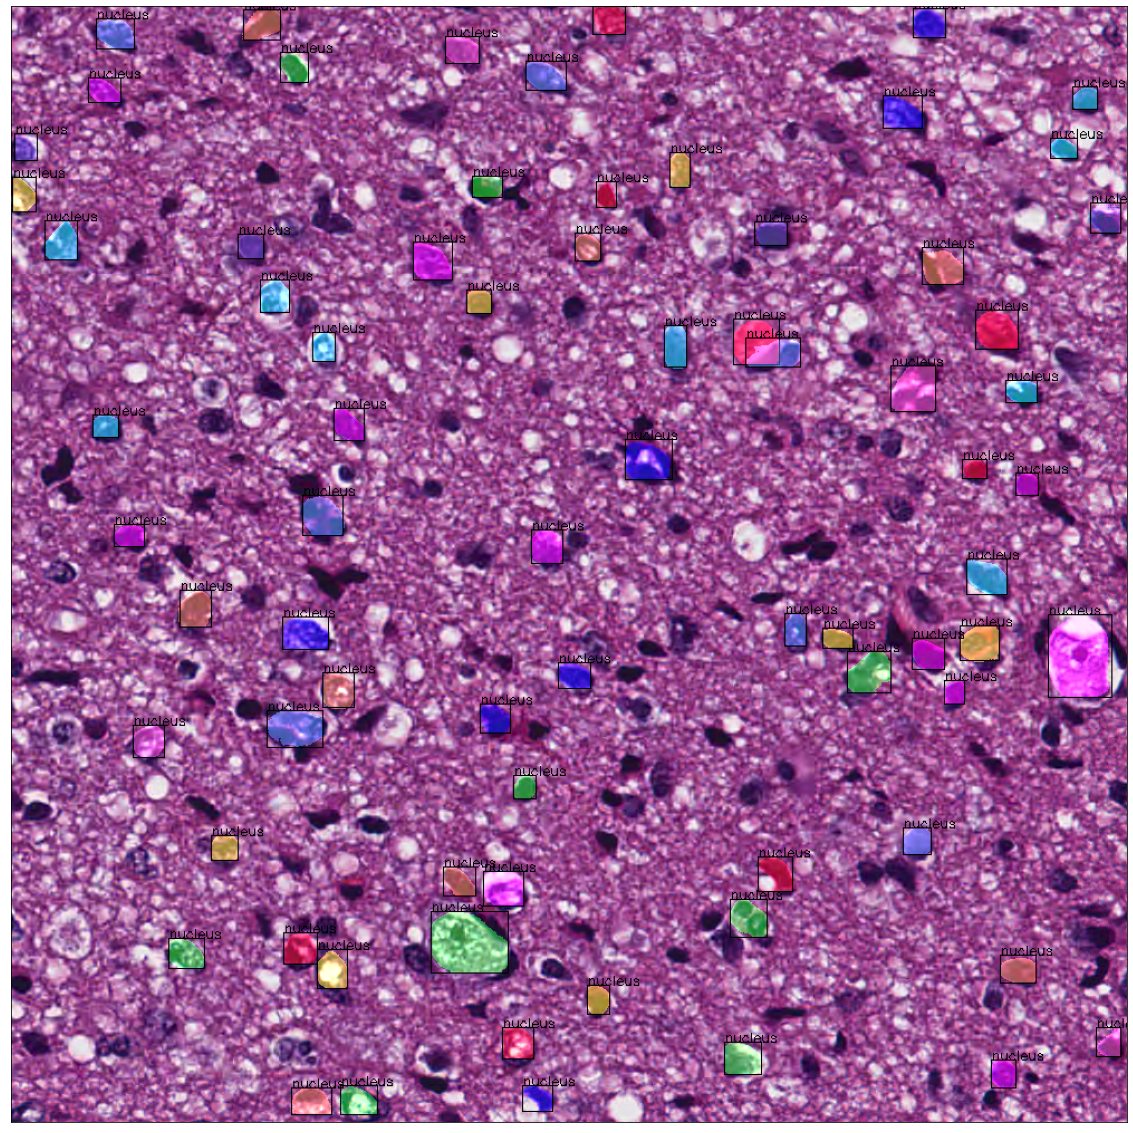

75


In [ ]:
num_det = segment_instance('/content/monusegTest/Tissue Images/TCGA-HT-8564-01Z-00-DX1.tif', confidence=0.5)
print(num_det)